In [1]:
!pip install --quiet pytorch-forecasting==1.0.0 comet_ml torch==2.1.0 lightning optuna==3.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.4/677.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 81.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import CometLogger, TensorBoardLogger

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet, NBeats
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss

#from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


## Hyperparameters

In [45]:
hyperparameters = {
    'max_prediction_length': 24,  # forecast 6 months
    'min_encoder_length': 24,
    'max_encoder_length': 720,  # use 3 days of history
    'training_cutoff_year': 2024,
    'batch_size': 120,
    'learning_rate': .005,
    'hidden_size': 64,
    'hidden_continuous_size': 32,
    'train_batches': 100,
    'num_cells': 512,
}

## Prepare Data

In [4]:
df = pd.read_csv('drive/MyDrive/colab/data.csv', index_col=0, parse_dates=True)

In [5]:
df['time_idx'] = range(len(df))
df['group'] = 1

### Transform categorical features to strings

In [6]:
df['group'] = df['group'].astype(str).astype('category')
df['Day'] = df['Day'].astype(str).astype('category')
df['Month'] = df['Month'].astype(str).astype('category')
df['Hour'] = df['Hour'].astype(str).astype('category')
df['Weekday'] = df['Weekday'].astype(str).astype('category')
df['Holiday'] = df['Holiday'].astype(str).astype('category')
df['Mod168'] = df['Mod168'].astype(str).astype('category')

### Create PyTorch Forecasting Dataset

In [7]:
df_train = df[df.index.year < hyperparameters['training_cutoff_year']]


In [19]:
training_tft = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="Price",
    group_ids=["group"],
    min_encoder_length=hyperparameters['min_encoder_length'],
    max_encoder_length=hyperparameters['max_encoder_length'],
    min_prediction_length=1,
    max_prediction_length=hyperparameters['max_prediction_length'],
    static_categoricals=["group"],
    # static_reals=[
    #     "avg_population_2017",
    #     "avg_yearly_household_income_2017"
    # ],
    time_varying_known_categoricals=[
        'Day',
        'Month',
        'Hour',
        'Weekday',
        'Holiday',
        'Mod168'
    ],
    # group of categorical variables can be treated as
    # one variable
    # variable_groups={"special_days": special_days},
    time_varying_known_reals=[
        "time_idx",
        "Year",
        "BalancingMarketPrice",
        "ForecastedDemandSupply"
    ],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        'Price'
    ],
    # use softplus with beta=1.0 and normalize by group
    target_normalizer=GroupNormalizer(
        groups=["group"]
    ),
    add_relative_time_idx=True,  # add as feature
    add_target_scales=True,  # add as feature
    add_encoder_length=True,  # add as feature
)
# create validation set (predict=True) which means to predict the
# last max_prediction_length points in time for each series
validation_tft = TimeSeriesDataSet.from_dataset(
    training_tft, df, predict=True, stop_randomization=True,
)# create dataloaders for model
train_tft_dataloader = training_tft.to_dataloader(
    train=True, batch_size=hyperparameters['batch_size'], num_workers=0
)
val_tft_dataloader = validation_tft.to_dataloader(
    train=False, batch_size=hyperparameters['batch_size'] * 10, num_workers=0
)

In [46]:
training_nbeats = TimeSeriesDataSet(
    df_train,
    time_idx="time_idx",
    target="Price",
    # categorical_encoders={"series": NaNLabelEncoder().fit(data.series)},
    group_ids=["group"],
    # only unknown variable is "value" - and N-Beats can also not take any additional variables
    time_varying_unknown_reals=["Price"],
    max_encoder_length=hyperparameters['max_encoder_length'],
    max_prediction_length=hyperparameters['max_prediction_length'],
)

validation_nbeats = TimeSeriesDataSet.from_dataset(training_nbeats, df, min_prediction_idx=len(df_train))
train_nbeats_dataloader = training_nbeats.to_dataloader(train=True, batch_size=hyperparameters['batch_size'], num_workers=0)
val_nbeats_dataloader = validation_nbeats.to_dataloader(train=False, batch_size=hyperparameters['batch_size'], num_workers=0)


# Models

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
# logger = CometLogger(api_key='O35hn5O1ER5tego7HI55dPH5a', project_name='pytorch-forecasting')
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=hyperparameters['train_batches'],  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

## Temporal Fusion Transformer

In [20]:
tft = TemporalFusionTransformer.from_dataset(
    training_tft,
    learning_rate=hyperparameters['learning_rate'],
    hidden_size=hyperparameters['hidden_size'],
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=hyperparameters['hidden_continuous_size'],
    loss=QuantileLoss(),
    # log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)

train_dataloader = train_tft_dataloader
val_dataloader = val_tft_dataloader
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Number of parameters in network: 317.5k


/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


## NBeats

In [47]:
net = NBeats.from_dataset(
    training_nbeats,
    learning_rate=hyperparameters['learning_rate'],
    weight_decay=1e-2,
    widths=[hyperparameters['hidden_size'], hyperparameters['num_cells']],
    backcast_loss_ratio=0.1
)

train_dataloader = train_nbeats_dataloader
val_dataloader = val_nbeats_dataloader

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


## Hyperparameter Optimization

### Find Learning Rate

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/callbacks/model_checkpoint.py:652: Checkpoint directory lightning_logs/lightning_logs/version_0/checkpoints exists and is not empty.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO: LR finder stopped early after 1701 steps due to diverging loss.
INFO:lightning.pytorch.tuner.lr_finder:LR finder stopped early after 1701 steps due to diverging loss.
ERROR: Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
ERROR:lightning.pytorch.tuner.lr_finder:Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.
INFO: Restoring states from the checkpoint path at /content/.lr_find_ebbae324-c33b-4aca-9636-c141ed7ab463.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_ebbae324-c33b-4aca-9636-c141ed7ab463.ckpt
INFO: Restored all states from the checkpoint at /content/.lr_find_ebbae324-c33b-4aca-9636-c141ed7ab463.ckpt
INFO:lightning.pytorch.utilities.rank_zero:Restored all states from the checkpoint at /content

suggested learning rate: None


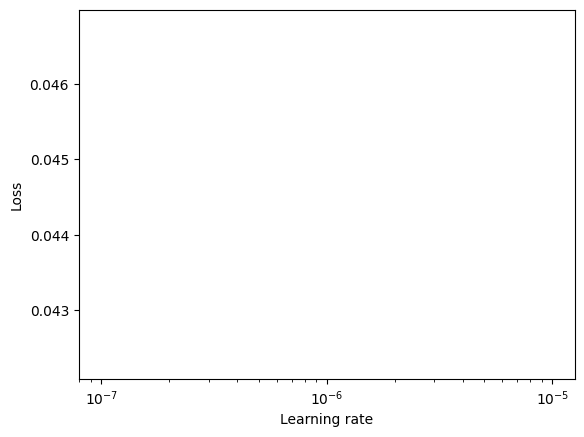

In [48]:
res = Tuner(trainer).lr_find(
    net,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

## Fitting

In [15]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 5.4 K  | train
3  | prescalers                         | ModuleDict                      | 576    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 20.8 K | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 45.8 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 38.3 K | train
7  | static_context_variable_selectio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [21]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [22]:
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="gpu"))
MAE()(predictions.output, predictions.y)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


tensor(25.7092, device='cuda:0')

In [37]:
raw_predictions.output.prediction

AttributeError: 'Tensor' object has no attribute 'plot'

In [33]:
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
#best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)

target = raw_predictions.x['encoder_target'][0][-24]
predictions =

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


IndexError: too many indices for tensor of dimension 0